<a href="https://colab.research.google.com/github/databyhuseyn/MachineLearning/blob/main/Time_series_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf


tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [2]:
import pandas as pd
import pathlib

path = pathlib.Path('/content/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv')

df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ['date', 'day_type', 'bus', 'rail', 'total'] # shorter names
df = df.sort_values('date').set_index('date')
df = df.drop('total', axis=1)    # no need for total, it's just bus + rail
df = df.drop_duplicates()   # remove duplicated months (2011-10 and 2014-07)

In [3]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


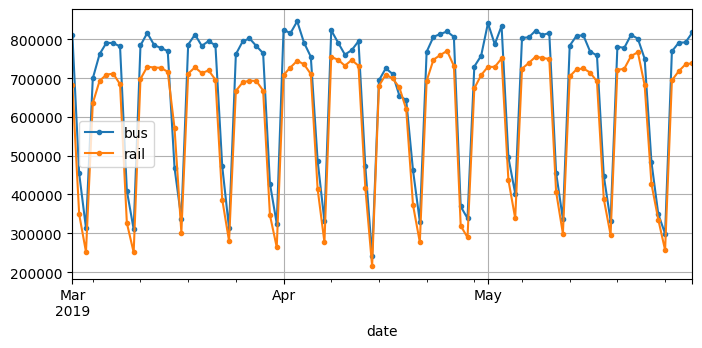

In [4]:
import matplotlib.pyplot as plt

df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

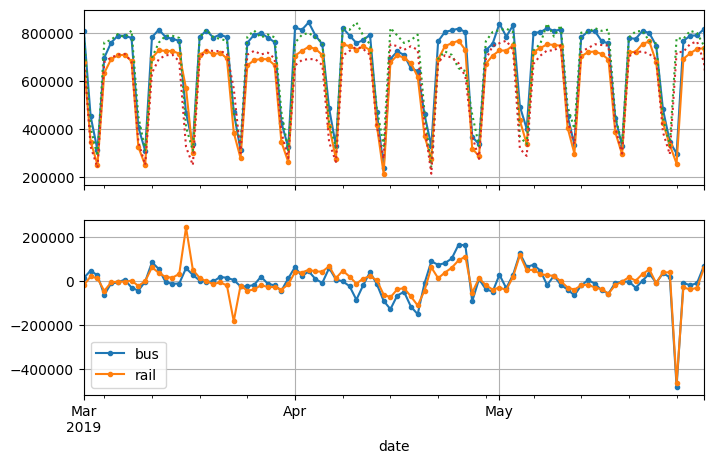

In [5]:
diff_7 = df[['bus', 'rail']].diff(7)['2019-03':'2019-05']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker='.')   # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':')  # lagged
diff_7.plot(ax=axs[1], grid=True, marker='.')  # 7 day difference time series
axs[0].set_ylim([170_000, 900_000]) # extra code - beautifies the plot
plt.show()

In [6]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [7]:
targets = df[['bus', 'rail']]['2019-03':'2019-05']
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

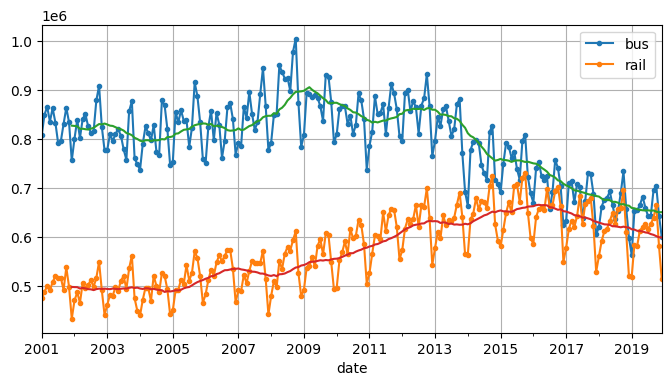

In [8]:
period = slice('2001', '2019')
df_monthly = df.resample("M").mean(numeric_only = True)
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

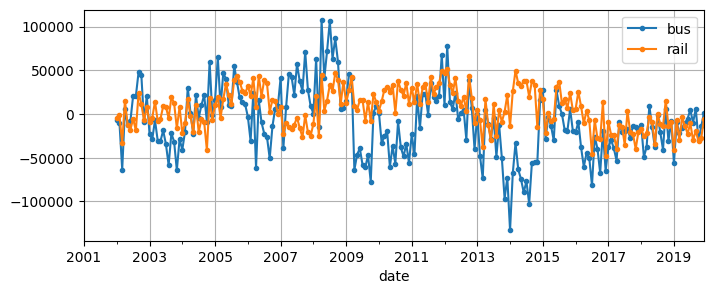

In [9]:
df_monthly.diff(12)[period].plot(grid=True, marker='.', figsize=(8, 3))
plt.show()

In [10]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q -U statsmodels

In [11]:
from statsmodels.tsa.arima.model import ARIMA
origin, today = '2019-01-01', '2019-05-31'
rail_series  = df.loc[origin:today]['rail'].asfreq('D')
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [12]:
y_pred[0]

427758.62641035335

In [13]:
df['rail'].loc['2019-06-01']

379044

In [14]:
df['rail'].loc['2019-05-25']

426932

In [15]:
origin, start_date, end_date = '2019-01-01', '2019-03-01', '2019-05-31'
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq('D')
y_preds = []
for today in time_period.shift(-1):
  model = ARIMA(rail_series[origin:today],     # train on data up to 'today'
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 7))
  model = model.fit()     # note that we retrain the model every day!
  y_pred = model.forecast()[0]
  y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [16]:
mae

32040.720089453378

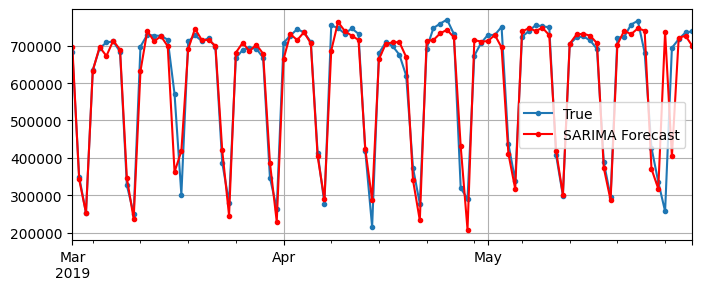

In [17]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label='True', ax=ax, marker='.', grid=True)
ax.plot(y_preds, color='r', marker='.', label='SARIMA Forecast')
plt.legend()
plt.show()

In [18]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],   # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [19]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
  for element in window_dataset:
    print(f'{element}', end=' ')
  print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [20]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
  print(f'{window_tensor}')

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [21]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [22]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [29]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [30]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [31]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 11ms/step - loss: 0.1647 - mae: 0.4407 - val_loss: 0.0133 - val_mae: 0.1314
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0157 - mae: 0.1403 - val_loss: 0.0113 - val_mae: 0.1206
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0114 - mae: 0.1175 - val_loss: 0.0073 - val_mae: 0.0917
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0085 - mae: 0.0992 - val_loss: 0.0071 - val_mae: 0.0910
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0075 - mae: 0.0921 - val_loss: 0.0060 - val_mae: 0.0810
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0070 - mae: 0.0884 - val_loss: 0.0054 - val_mae: 0.0763
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0063 - mae: 0.0836 - val_loss: 0.0051 - val_mae: 0.0730
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0061 - 

In [32]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 8ms/step - loss: 0.0023 - mae: 0.0382


38212.69050240517

# Using a simple RNN

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [38]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor='val_mae', patience=50, restore_best_weights=True)
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
  history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                      callbacks=[early_stopping_cb])
  valid_loss, valid_mae = model.evaluate(valid_set)
  return valid_mae * 1e6

In [39]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 25ms/step - loss: 0.0208 - mae: 0.1699 - val_loss: 0.0127 - val_mae: 0.1134
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0121 - mae: 0.1154 - val_loss: 0.0126 - val_mae: 0.1123
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0119 - mae: 0.1155 - val_loss: 0.0122 - val_mae: 0.1117
Epoch 4/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0117 - mae: 0.1153 - val_loss: 0.0121 - val_mae: 0.1112
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0116 - mae: 0.1150 - val_loss: 0.0119 - val_mae: 0.1107
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0115 - mae: 0.1147 - val_loss: 0.0118 - val_mae: 0.1102
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0113 - mae: 0.1145 - val_loss: 0.0116 - val_mae: 0.1097
Epoch 8/500
33/33 [==============================] - 1s 17ms/step - loss: 0.

102733.91008377075

In [42]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [43]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 32ms/step - loss: 0.0192 - mae: 0.1498 - val_loss: 0.0033 - val_mae: 0.0592
Epoch 2/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0050 - mae: 0.0705 - val_loss: 0.0024 - val_mae: 0.0502
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0048 - mae: 0.0700 - val_loss: 0.0051 - val_mae: 0.0796
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0037 - mae: 0.0581 - val_loss: 0.0020 - val_mae: 0.0415
Epoch 5/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0031 - mae: 0.0500 - val_loss: 0.0020 - val_mae: 0.0388
Epoch 6/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0034 - mae: 0.0561 - val_loss: 0.0022 - val_mae: 0.0406
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0034 - mae: 0.0549 - val_loss: 0.0020 - val_mae: 0.0386
Epoch 8/500
33/33 [==============================] - 0s 13ms/step - loss: 0.

29024.947434663773

# Deep RNNs

In [44]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [45]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=1e-2)

Epoch 1/500
33/33 [==============================] - 8s 87ms/step - loss: 0.0542 - mae: 0.2309 - val_loss: 0.0136 - val_mae: 0.1446
Epoch 2/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0113 - mae: 0.1212 - val_loss: 0.0071 - val_mae: 0.0932
Epoch 3/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0081 - mae: 0.0948 - val_loss: 0.0026 - val_mae: 0.0514
Epoch 4/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0051 - mae: 0.0688 - val_loss: 0.0023 - val_mae: 0.0451
Epoch 5/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0049 - mae: 0.0648 - val_loss: 0.0023 - val_mae: 0.0456
Epoch 6/500
33/33 [==============================] - 2s 59ms/step - loss: 0.0046 - mae: 0.0637 - val_loss: 0.0021 - val_mae: 0.0414
Epoch 7/500
33/33 [==============================] - 2s 53ms/step - loss: 0.0044 - mae: 0.0622 - val_loss: 0.0029 - val_mae: 0.0549
Epoch 8/500
33/33 [==============================] - 1s 33ms/step - loss: 0.

28130.410239100456

# Multivariate time series

In [47]:
df_mulvar = df[['bus', 'rail']] / 1e6  # use both bus & rail series as input
df_mulvar['next_day_type'] = df['day_type'].shift(-1) # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [48]:
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,False,False,True
2001-01-02,0.780827,0.501952,False,False,True
2001-01-03,0.824923,0.536432,False,False,True
2001-01-04,0.870021,0.550011,False,False,True
2001-01-05,0.890426,0.557917,True,False,False
...,...,...,...,...,...
2021-11-26,0.257700,0.189694,True,False,False
2021-11-27,0.237839,0.187065,False,True,False
2021-11-28,0.184817,0.147830,False,False,True


In [53]:
import numpy as np
mulvar_train = df_mulvar['2016-01':'2018-12'].astype(np.float64)
mulvar_valid = df_mulvar['2019-01':'2019-05'].astype(np.float64)
mulvar_test = df_mulvar['2019-06':].astype(np.float64)

In [54]:
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train['rail'][seq_length:], # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid['rail'][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

In [55]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [56]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=5e-2)

Epoch 1/500
33/33 [==============================] - 3s 34ms/step - loss: 0.0397 - mae: 0.2000 - val_loss: 0.0020 - val_mae: 0.0514
Epoch 2/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0027 - mae: 0.0533 - val_loss: 0.0018 - val_mae: 0.0495
Epoch 3/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0017 - mae: 0.0405 - val_loss: 6.7974e-04 - val_mae: 0.0252
Epoch 4/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0016 - mae: 0.0395 - val_loss: 0.0010 - val_mae: 0.0352
Epoch 5/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0015 - mae: 0.0375 - val_loss: 0.0010 - val_mae: 0.0339
Epoch 6/500
33/33 [==============================] - 2s 45ms/step - loss: 0.0015 - mae: 0.0379 - val_loss: 7.2083e-04 - val_mae: 0.0268
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0359 - val_loss: 6.2023e-04 - val_mae: 0.0237
Epoch 8/500
33/33 [==============================] - 0s 13ms/ste

21899.26616847515

In [57]:
0.0273 * 1e6

27300.0

In [59]:
mulvar_train

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,1.0,0.0,0.0
2016-01-02,0.448859,0.365509,0.0,1.0,0.0
2016-01-03,0.340540,0.287661,0.0,0.0,1.0
2016-01-04,0.829429,0.703185,0.0,0.0,1.0
2016-01-05,0.846789,0.727716,0.0,0.0,1.0
...,...,...,...,...,...
2018-12-27,0.509948,0.453029,0.0,0.0,1.0
2018-12-28,0.577497,0.493961,1.0,0.0,0.0
2018-12-29,0.394088,0.307105,0.0,1.0,0.0


In [60]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
  mulvar_train.to_numpy(),
  targets=mulvar_train[['bus','rail']][seq_length:],
  sequence_length=seq_length,
  batch_size=32,
  shuffle=True,
  seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
  mulvar_valid.to_numpy(),
  targets=mulvar_valid[['bus','rail']][seq_length:],
  sequence_length=seq_length,
  batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
  tf.keras.layers.Dense(2)])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=2e-2)

Epoch 1/500
33/33 [==============================] - 3s 35ms/step - loss: 0.0474 - mae: 0.2052 - val_loss: 0.0053 - val_mae: 0.0736
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0052 - mae: 0.0667 - val_loss: 0.0027 - val_mae: 0.0495
Epoch 3/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0035 - mae: 0.0524 - val_loss: 0.0017 - val_mae: 0.0359
Epoch 4/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0028 - mae: 0.0486 - val_loss: 0.0019 - val_mae: 0.0454
Epoch 5/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0025 - mae: 0.0470 - val_loss: 0.0012 - val_mae: 0.0322
Epoch 6/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0447 - val_loss: 0.0016 - val_mae: 0.0416
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - mae: 0.0450 - val_loss: 0.0011 - val_mae: 0.0325
Epoch 8/500
33/33 [==============================] - 1s 14ms/step - loss: 0.

25387.98563182354